# Masked Autoencoder

The masked autoencoder is an architecture that was proposed to use a Vision Transformer to learn useful representations of the image by implementing the encoder and decoder blocks of the autoencoder as transformer encoder and decoder blocks with multi headed attention instead of using convolutional neural networks. Using the proposed architecture the images could be masked upto 70% and still be reconstructed with an acceptable amount of loss. In this notebook, we will implement the masked autoencoder from scratch and understand the purpose for each component, then we will train it on the Food101 dataset, we will see how the model is able to reconstruct the original images from the highly masked inputs.

Reference Paper: [Masked Autoencoders Are Scalable Vision Learners](https://arxiv.org/pdf/2111.06377)

Prerequisites:
- Basic understanding of Neural Network
- Understood Transformer and ViT concepts



In [2]:
import torchvision
import torch
import torch.nn as nn 
import torchvision.transforms as transforms
import torch.nn.functional as F 
import numpy as np 
import matplotlib.pyplot as plt 
from torch.utils.data import DataLoader, random_split 
from time import time

/Users/rishabhrao/opt/miniconda3/envs/dl/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1. Exploring and Preparation of Data

In [3]:
# Image Parameters
IMG_HEIGHT, IMG_WIDTH = 224, 224
batch_size = 32

In [7]:
transform = transforms.Compose([
    transforms.Resize((IMG_HEIGHT, IMG_WIDTH)),
    transforms.ToTensor(),
    transforms.Normalize((0.5459, 0.4437, 0.3427), (0.2924, 0.2700, 0.2730))
])

dataset = torchvision.datasets.Food101(root='../data', download=True, transform=transform)
split_size = 0.8
train_size = int(split_size * len(dataset))
val_size = len(dataset) - train_size

train_set, val_set = random_split(dataset, (train_size, val_size))
trainloader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2, drop_last=True)
valloader = DataLoader(val_set, batch_size=batch_size, shuffle=False, num_workers=2, drop_last=True)

print(f'Train Size: {train_size}')
print(f'Val Size: {val_size}')

Train Size: 60600
Val Size: 15150


Similar to a Vision Transformer, in a masked autoencoder since it is built on the principle of a ViT, the image is fed to the model as a sequence of patches, given below are functions to convert an image into a sequence of patches and similarly the reverse operation as well as a function to visualise the images.

In [10]:
patch_h, patch_w = 16, 16
num_patch = (IMG_HEIGHT // patch_h) * (IMG_WIDTH // patch_w)

In [29]:
def get_patches(imgs):
    """
    Takes a batch of images and returns batches of sequence of patches for each indivual image

    Input shape: (B, C, H, W)
    Output Shape: (B, P, C, H, W)
    """

    B, C, H, W = imgs.shape

    assert H % patch_h == 0 and W % patch_w == 0, "Image dimensions not compatible with given patch dimensions"

    # Patch extraction
    patches = imgs.unfold(2, patch_h, patch_h).unfold(3, patch_w, patch_w)
    patches = patches.contiguous().view(B, C, -1, patch_h, patch_w) # (B, C, P, H, W)
    patches = patches.permute(0, 2, 1, 3, 4) # (B, P, C, H, W)

    return patches

def get_images(patches):
    """ 
    Takes batches of image patches and returns the batch of images

    Input Shape: (B, P, C, H, W)
    Output Shape: (B, C, H, W)
    """

    B, P, C, h, w = patches.shape

    nrow_patch = IMG_WIDTH // patch_w
    ncol_patch = IMG_HEIGHT // patch_h

    assert P == ncol_patch * nrow_patch, "Patch dimensions dont match original images"

    patches = patches.permute(0, 2, 1, 3, 4)  # (B, C, P, h, w)
    patches = patches.contiguous().view(B, C, nrow_patch, ncol_patch, h, w)
    patches = patches.permute(0, 1, 2, 4, 3, 5) # (B, C, nrow_patch, h, ncol_patch, w)
    patches = patches.contiguous().view(B, C, nrow_patch*h, ncol_patch*w) # (B, C, H, W)

    return patches

def visualise_images(data, image_label=None):
    """ 
    Takes image and visualises it
    """
    img = data.detach().numpy().transpose((1, 2, 0))
    mean = np.array([0.5459, 0.4437, 0.3427])
    std = np.array([0.2924, 0.2700, 0.2730])
    img = std*img + mean
    img = np.clip(img, 0, 1)
    return img

In [55]:
train_imgs, train_labels= next(iter(trainloader))
train_imgs.shape, train_labels.shape

(torch.Size([32, 3, 224, 224]), torch.Size([32]))

Lets ensure that the result of take patches and reconstructing the image is the same as original image.

torch.Size([3, 224, 224])


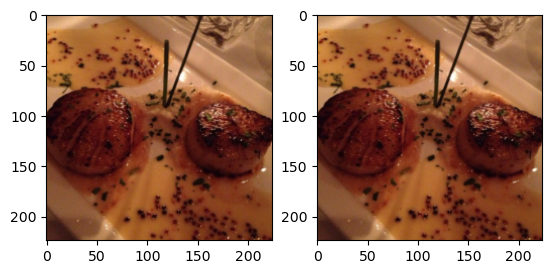

In [31]:
img = train_imgs[3]
fig, axes = plt.subplots(1, 2)
axes[0].imshow(visualise_images(img))

img = img.reshape(1, *img.shape)
img = get_images(get_patches(img))[0]
print(img.shape)
axes[1].imshow(visualise_images(img))

Now that we know there is no issue in data reconstruction lets move on to the actual masked auto encoder.

## 2. Implementation of Masked Autoencoder

In [105]:
n_embd = 180
num_heads = 5
head_size = n_embd // num_heads
num_enc_blocks = 4
num_dec_blocks = 2
num_vpatch = int(0.4*num_patch)
num_mpatch = num_patch - num_vpatch
eval_iters = 10
learning_rate = 1e-3
eval_interval = 500
num_epochs = 1

In [3]:
@torch.no_grad()
def estimate_losses():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        k = 0
        loader = trainloader if split == 'train' else valloader
        for imgs, _ in iter(trainloader):
            batch_patches = get_patches(imgs)
            B, P, C, h, w = batch_patches.shape
            batch_patches = batch_patches.reshape(B, P, C*h*w)
            re_img, loss, masked_img = model(batch_patches)
            losses[k] = loss.item()
            k+= 1
            if k == eval_iters:
                break
        out[split] = losses.mean()
    model.train()
    return out

class Head(nn.Module):

    def __init__(self, head_size) -> None:
        super().__init__()
        self.key = nn.Linear(n_embd, head_size)
        self.query = nn.Linear(n_embd, head_size)
        self.value = nn.Linear(n_embd, head_size)
    
    def forward(self, x):
        k = self.key(x)
        q = self.query(x)
        wei = q @ k.transpose(-2, -1)
        wei = F.softmax(wei, dim=-1)
        v = self.value(x)
        out = wei @ v 
        return out

class MultiHeadedAttention(nn.Module):

    def __init__(self, num_heads, head_size) -> None:
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.c_proj = nn.Linear(n_embd, n_embd)
    
    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.c_proj(out)
        return out
    
class MLP(nn.Module):

    def __init__(self) -> None:
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4*n_embd),
            nn.GELU(),
            nn.Linear(4*n_embd, n_embd)
        )
    
    def forward(self, x):
        out = self.net(x)
        return out

class Block(nn.Module):

    def __init__(self) -> None:
        super().__init__()
        self.attn = MultiHeadedAttention(num_heads, head_size)
        self.mlp = MLP()
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        x = x + self.attn(self.ln1(x))
        x = x + self.mlp(self.ln1(x))
        return x
    
def get_position_enc(num_patch, n_embd):

    assert n_embd % 2 == 0, f"{n_embd} should be even for positional encoding"

    y_pos = torch.arange(0, num_patch, dtype=torch.float).unsqueeze(1)
    x_pos = torch.arange(0, num_patch, dtype=torch.float).unsqueeze(1)
    div_term = torch.exp(torch.arange(0, n_embd // 2, 2).float() * (-torch.log(torch.tensor(1000.0)) / (n_embd // 2)))

    pos_encoding = torch.zeros((num_patch, n_embd))
    pos_encoding[:, 0::4] = torch.sin(y_pos * div_term)
    pos_encoding[:, 1::4] = torch.cos(y_pos * div_term)
    pos_encoding[:, 2::4] = torch.sin(x_pos * div_term)
    pos_encoding[:, 3::4] = torch.cos(x_pos * div_term)

    return pos_encoding

class MaskedAutoEncoder(nn.Module):

    def __init__(self) -> None:
        super().__init__()
        self.patch_embedding = nn.Linear(patch_h*patch_w*3, n_embd)
        self.pos_embedding = get_position_enc(num_patch, n_embd)
        self.encoder = nn.Sequential(*[Block() for _ in range(num_enc_blocks)])
        self.decoder = nn.Sequential(*[Block() for _ in range(num_dec_blocks)])
        self.final_ln = nn.Linear(n_embd, patch_h*patch_w*3)
        self.mask_patch = torch.randn((1, patch_h*patch_w*3))

    def forward(self, x, returned_masked=False):
        org_img = x.clone().detach()
        patch_tokens = self.patch_embedding(x) # (B, P, n_embd)
        patch_tokens += self.pos_embedding
        mask_token = self.patch_embedding(self.mask_patch)

        # Sample some as visible patches
        visible_indices = torch.randperm(num_patch-1)[:num_vpatch]
        masked_indices = torch.tensor([i for i in range(num_patch) if i not in visible_indices])
        shuffled_indices = torch.cat([visible_indices, masked_indices])
        reversed_indices = torch.argsort(shuffled_indices)
        visible_patch = patch_tokens[:, visible_indices]

        # Encoder working
        enc_out = self.encoder(visible_patch)
        mask_tokens = torch.stack([torch.cat([mask_token for _ in range(num_mpatch)]) for _ in range(batch_size)])
        concat_out = torch.cat([enc_out, mask_tokens], dim=1)
        
        dec_inp = concat_out[:, reversed_indices]
        dec_inp += self.pos_embedding
        dec_out = self.decoder(dec_inp)

        re_img = self.final_ln(dec_out)
        
        loss = F.mse_loss(re_img, org_img)

        masked_img = None

        if not returned_masked:
            zero_patch = torch.zeros((1, patch_h*patch_w*3))
            zero_patches = torch.stack([torch.cat([zero_patch for _ in range(num_mpatch)]) for _ in range(batch_size)])
            real_patches = org_img[:, visible_indices]
            concat_img = torch.cat([real_patches, zero_patches], dim=1)
            masked_img = concat_img[:, reversed_indices]

        return re_img, loss, masked_img

In [106]:
model = MaskedAutoEncoder()
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
curr_iter = 0
step_losses = []
epoch_losses = {'train': [], 'val': []}

In [107]:
for epoch in range(num_epochs):
    for images, labels in iter(trainloader):

        # Getting patches
        batch_patches = get_patches(images)
        B, P, C, h, w = batch_patches.shape
        batch_patches = batch_patches.reshape(B, P, C*h*w)
        re_img, loss, masked_img = model(batch_patches)

        if curr_iter % eval_interval == 0:
            losses_out = estimate_losses()
            print(f"Step {curr_iter}: train loss {losses_out['train']} val loss {losses_out['val']}")

        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()
        curr_iter += 1
        step_losses.append(loss.item())

    epoch_loss = estimate_losses()
    epoch_losses['train'].append(epoch_loss['train'])
    epoch_losses['val'].append(epoch_loss['val'])

torch.Size([32, 196, 768])
torch.Size([32, 196, 768])
torch.Size([32, 196, 768])
torch.Size([32, 196, 768])
torch.Size([32, 196, 768])
torch.Size([32, 196, 768])
torch.Size([32, 196, 768])
torch.Size([32, 196, 768])
torch.Size([32, 196, 768])
torch.Size([32, 196, 768])
torch.Size([32, 196, 768])
torch.Size([32, 196, 768])
torch.Size([32, 196, 768])
torch.Size([32, 196, 768])
torch.Size([32, 196, 768])
torch.Size([32, 196, 768])


In [ ]:
re_images = None
for images, labels in iter(trainloader):
    imgs_target = images.clone().detach()
    batch_patches = get_patches(images)
    B, P, C, h, w = batch_patches.shape
    batch_patches = batch_patches.reshape(B, P, C*h*w)
    re_img, loss, masked_img = model(batch_patches)
    re_img = re_img.reshape(B, P, C, h, w)
    masked_img = masked_img.reshape(B, P, C, h, w)
    pred_imgs = get_images(re_img)
    masked_imgs = get_images(masked_img)

    fig, axes = plt.subplots(5, 3, figsize=(8, 8))
    for i in range(0, 5):
        true_img = visualise_images(imgs_target[i])
        pred_img = visualise_images(pred_imgs[i])
        mask_img = visualise_images(masked_imgs[i])

        axes[i, 0].imshow(true_img)
        axes[i, 0].axis('off')
        axes[i, 1].imshow(mask_img)
        axes[i, 1].axis('off')
        axes[i, 2].imshow(pred_img)
        axes[i, 2].axis('off')

    break